# Data description & Problem statement: 
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. Please check the description at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

* This dataset is subset of original dataset. It's slightly imbalanced. The data has 11,162 rows and 17 columns.
* This is a classification problem. The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the missing values, etc.)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicated values, etc. 
- Basic data exploration
- Preparing data for Machine Learning:
    - One-hot-encoding of categorical features
    - Vector Assembling
    - Splitting data into training & test parts (I use the training part for training & hyperparameter tuning of models, test part for the final evaluation of models)
      
 # Model Training: 
- I separately train following models:
     - Logistic Regression (LR)
     - Random Forest (RF)
     - Gradient Boosting Trees (GBTs)
     
 Note: I use Grid-Search technique to find optimal hyper-parameters of each model.

 # Model Evaluation: 
- I separately evaluate the best LR, RF and GBT models, by calculating/plotting following mertics on Test dataset:
     - roc_auc score
     - f1 score
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision
 
 
- Calculating the Feature Importance with RF and GBTs models.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import findspark 
findspark.init('/home/rhashemee/spark-2.1.0-bin-hadoop2.7')

import pyspark
import sklearn
import numpy as np
import pandas as pd
import imblearn as im
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pyspark.sql import SparkSession
my_spark=SparkSession.builder.appName('bank_deposit').getOrCreate()

In [3]:
df=my_spark.read.csv('bank.csv', header=True, inferSchema=True)

In [4]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [5]:
pd.DataFrame(df.take(5), columns=df.columns)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [6]:
df.groupBy('deposit').count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



In [7]:
df = df.drop('day', 'month')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [8]:
# Preparing Data for Machine Learning: ___________________________

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# One-Hot-Encoding of Categorical features:
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + '_Index')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "_classVec")
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')

stages += [label_stringIdx]

# Continuous features: 
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

# Vector assembling:
assemblerInputs = [c + "_classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [9]:
# Pipeline: ___________________________________
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df_piped = pipelineModel.transform(df)

selectedCols = ['label', 'features'] + cols
df_piped = df_piped.select(selectedCols)
df_piped.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [10]:
train, test = df_piped.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7827
Test Dataset Count: 3335


# 1) Logistic Regression Model: 

In [11]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.BinaryClassificationEvaluator(metricName="areaUnderROC")

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(lr.regParam, [0, 0.1, 1, 10, 100])
grid=grid.addGrid(lr.elasticNetParam, [0, 0.1, 1])
grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=lr,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [12]:
# fit the model:
models=cv.fit(train)
best_lr=models.bestModel

# Best hyper-parameters: 
java_model = best_lr._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})

Best hyper-parameters:  {'regParam': 0.0, 'elasticNetParam': 0.0}


In [13]:
# Prediction on test dataset:
test_predictions = best_lr.transform(test)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[0.25295905421680...|[0.56290469047491...|       0.0|
|  0.0|[2.00330981424455...|[0.88114414948791...|       0.0|
|  0.0|[1.09310344940380...|[0.74896567076532...|       0.0|
|  0.0|[0.22763160968371...|[0.55666344002016...|       0.0|
|  0.0|[2.73828748035356...|[0.93924845242235...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
print('Training roc_auc score: ', round(best_lr.summary.areaUnderROC, 2))
print('Validation roc_auc score: ', round(best_lr.evaluate(test).areaUnderROC,2), '\n')

print('Training average precision: ', round(evaluator.evaluate(best_lr.transform(train), {evaluator.metricName: 'areaUnderPR'}), 2))
print('Validation average precision: ', round(evaluator.evaluate(best_lr.transform(test), {evaluator.metricName: 'areaUnderPR'}), 2), '\n')

my_eval= MulticlassClassificationEvaluator(metricName='f1')
print('Training f1 score: ', round(my_eval.evaluate(best_lr.transform(train)),2))
print('Validation f1 score: ', round(my_eval.evaluate(best_lr.transform(test)),2))

Training roc_auc score:  0.89
Validation roc_auc score:  0.88 

Training average precision:  0.85
Validation average precision:  0.86 

Training f1 score:  0.8
Validation f1 score:  0.8


Confusion matrix, without normalization
[[1457  271]
 [ 385 1222]]
Normalized confusion matrix
[[0.84 0.16]
 [0.24 0.76]]


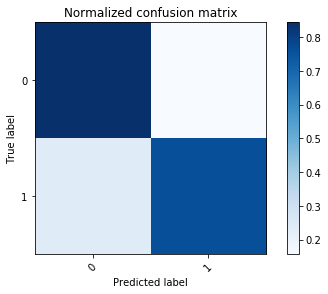

In [15]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

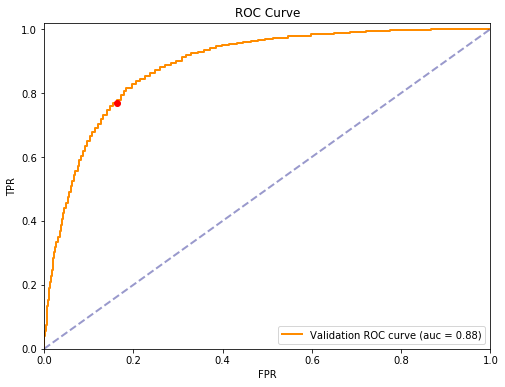

In [16]:
# ROC curve:______________________________________
validation_accuracy=best_lr.evaluate(test)
roc=validation_accuracy.roc.toPandas()
roc_auc=validation_accuracy.areaUnderROC

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(roc['FPR'],roc['TPR'], color='darkorange', lw=2, label='Validation ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')

plt.xlim([0.0, 1])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")

recall=validation_accuracy.recallByThreshold.toPandas()
recall=recall[np.round(recall['threshold'], 2)==0.5]['recall']
roc=validation_accuracy.roc.toPandas().iloc[recall.index[0]+1]
plt.plot(roc[0], roc[1], 'or')

plt.show()

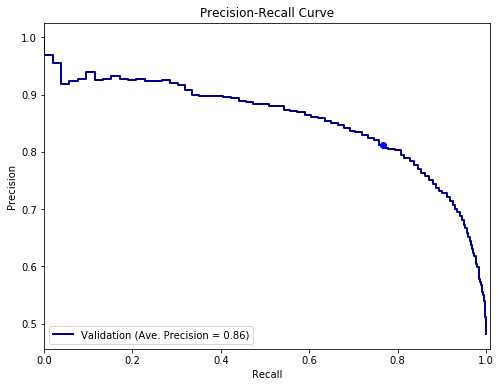

In [17]:
# Precision-Recall curve: ____________________________________________
validation_accuracy=best_lr.evaluate(test)
pr_test=validation_accuracy.pr.toPandas()

from pyspark.ml.evaluation import BinaryClassificationEvaluator
my_eval=BinaryClassificationEvaluator(metricName='areaUnderPR')
apr_test=my_eval.evaluate(best_lr.transform(test))

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(pr_test['recall'],pr_test['precision'], color='darkblue', lw=2, label='Validation (Ave. Precision = %0.2f)' % apr_test)

plt.xlim([0, 1.01])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

p_test=validation_accuracy.precisionByThreshold.toPandas()
r_test=validation_accuracy.recallByThreshold.toPandas()
p_test=p_test[np.round(p_test['threshold'], 2)==0.5]['precision']
r_test=r_test[np.round(r_test['threshold'], 2)==0.5]['recall']
plt.plot(r_test, p_test, 'ob')

plt.show()

# 2) Random Forest Model: 

In [18]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.BinaryClassificationEvaluator(metricName="areaUnderROC")

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()
grid=grid.addGrid(rf.maxDepth, [6])
grid=grid.addGrid(rf.numTrees, [50])
grid=grid.addGrid(rf.maxBins, [4, 8])

grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=rf,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [19]:
# fit the model:
models=cv.fit(train)
best_rf=models.bestModel

# Best hyper-parameters: 
java_model = best_rf._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})

Best hyper-parameters:  {'maxDepth': 6, 'maxBins': 8, 'numTrees': 50}


In [20]:
# Prediction on test dataset:
test_predictions = best_rf.transform(test)
test_predictions.select('label', 'rawPrediction', 'probability', 'prediction').show(5)

+-----+--------------------+--------------------+----------+
|label|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+----------+
|  0.0|[27.2994448883136...|[0.54598889776627...|       0.0|
|  0.0|[28.9099476649431...|[0.57819895329886...|       0.0|
|  0.0|[35.7351552374171...|[0.71470310474834...|       0.0|
|  0.0|[25.8870462957745...|[0.51774092591549...|       0.0|
|  0.0|[39.1562493946171...|[0.78312498789234...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

my_eval= BinaryClassificationEvaluator(metricName='areaUnderROC')
print('Training roc_auc score: ', round(my_eval.evaluate(best_rf.transform(train)),2))
print('Validation roc_auc score: ', round(my_eval.evaluate(best_rf.transform(test)),2), '\n')

print('Training average precision: ', round(evaluator.evaluate(best_rf.transform(train), {evaluator.metricName: 'areaUnderPR'}), 2))
print('Validation average precision: ', round(evaluator.evaluate(best_rf.transform(test), {evaluator.metricName: 'areaUnderPR'}), 2), '\n')

my_eval= MulticlassClassificationEvaluator(metricName='f1')
print('Training f1 score: ', round(my_eval.evaluate(best_rf.transform(train)),2))
print('Validation f1 score: ', round(my_eval.evaluate(best_rf.transform(test)),2))

Training roc_auc score:  0.9
Validation roc_auc score:  0.89 

Training average precision:  0.88
Validation average precision:  0.86 

Training f1 score:  0.82
Validation f1 score:  0.82


Confusion matrix, without normalization
[[1408  320]
 [ 282 1325]]
Normalized confusion matrix
[[0.81 0.19]
 [0.18 0.82]]


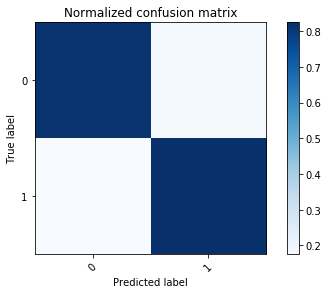

In [22]:
# Plot a confusion matrix:
# cm is the confusion matrix, names are the names of the classes.

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

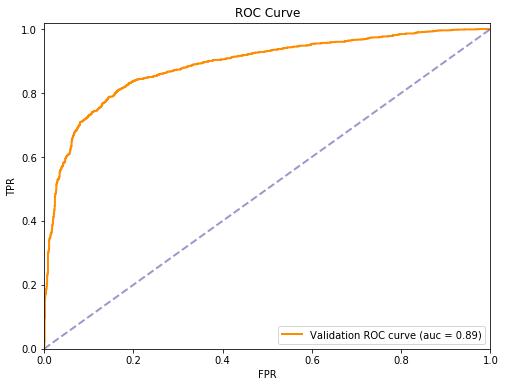

In [23]:
# ROC curve:______________________________________
prediction = best_rf.transform(test)
results= prediction.select(['probability', 'label']).collect()
results = [(i[0][0], 1.0-i[1]) for i in results]

from sklearn.metrics import roc_curve, auc
 
fpr= dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results]
y_score = [i[0] for i in results]
 
fpr, tpr, threshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8,6)) 

plt.step(fpr, tpr, color='darkorange', lw=2, label='Validation ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')

plt.xlim([0.0, 1])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")


plt.show()

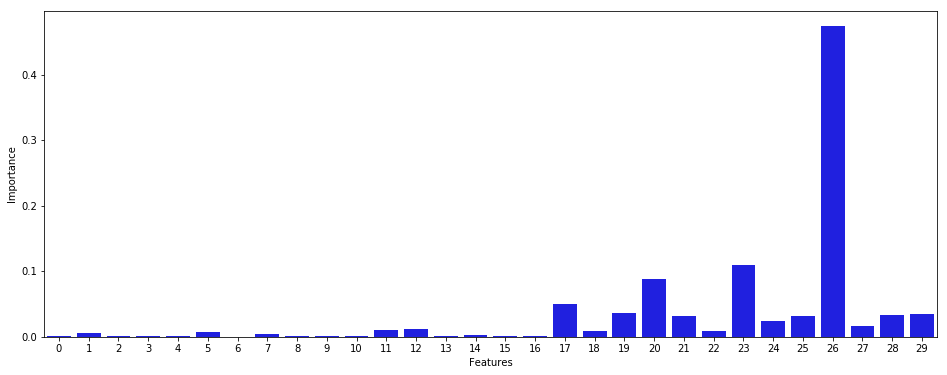

In [24]:
# Feature Importance: 
im=best_rf.featureImportances

# Plot:
c1=pd.DataFrame(im.toArray(),  columns=["Importance"])
c2=pd.DataFrame(np.arange(im.toArray().shape[0]), columns=["Features"])

fig, ax = plt.subplots(figsize=(16, 6)) 
sns.barplot(x="Features", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)

plt.show()

# 3) Gradient-Boosted Trees:

In [25]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(featuresCol = 'features', labelCol = 'label')

# creating the Evaluator: 
from  pyspark.ml import evaluation 

evaluator=evaluation.MulticlassClassificationEvaluator(metricName='f1')

# creating the Grid of Parameters: 
from pyspark.ml import tuning

grid=tuning.ParamGridBuilder()

grid=grid.addGrid(gb.maxDepth, [2, 4, 6])
grid=grid.addGrid(gb.maxIter, [10, 20])
grid=grid.addGrid(gb.maxBins, [24, 64])

grid=grid.build()

# making the Validator:
cv=tuning.CrossValidator(estimator=gb,
                         estimatorParamMaps=grid,
                         evaluator=evaluator,
                         numFolds=3,
                         seed=42)

In [26]:
# fit the model:
models=cv.fit(train)
best_gb=models.bestModel

# Best hyper-parameters: 
java_model = best_gb._java_obj
print("Best hyper-parameters: ",  {param.name: java_model.getOrDefault(java_model.getParam(param.name)) 
                                                                                 for param in grid[0]})

Best hyper-parameters:  {'maxIter': 20, 'maxBins': 64, 'maxDepth': 4}


In [27]:
print("Training f1 score:  ", round(evaluator.evaluate(best_gb.transform(train)),2))
print("Validation f1 score:  ", round(evaluator.evaluate(best_gb.transform(test)),2))

Training f1 score:   0.83
Validation f1 score:   0.82


In [28]:
# Prediction on test dataset:
test_predictions = best_gb.transform(test)
test_predictions.select('label', 'prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



Confusion matrix, without normalization
[[1426  302]
 [ 291 1316]]
Normalized confusion matrix
[[0.83 0.17]
 [0.18 0.82]]


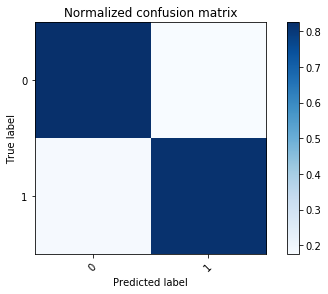

In [29]:
# Plot a confusion matrix:

class_names=["0", "1"]
    
# Compute confusion matrix:
from sklearn.metrics import confusion_matrix
y_test=test.select('label')
y_pred=test_predictions.select('prediction')

y_test = y_test.toPandas()
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_test, y_pred)

np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

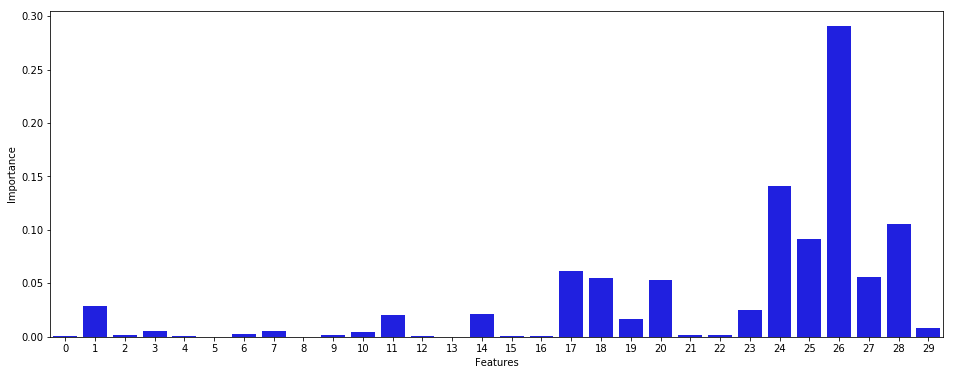

In [31]:
# Feature Importance: 
im=best_gb.featureImportances

# Plot:
c1=pd.DataFrame(im.toArray(),  columns=["Importance"])
c2=pd.DataFrame(np.arange(im.toArray().shape[0]), columns=["Features"])

fig, ax = plt.subplots(figsize=(16, 6)) 
sns.barplot(x="Features", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)

plt.show()